Step 1:  Joining patients.csv and appointments.csv and keeping only matching records.

In [1]:
#Importing Patients.csv and appointments.csv from git and storing them in separate pandas dataframes

import pandas as pd
import io
import requests

url="https://raw.githubusercontent.com/abeasock/coding_assessment/master/patients.csv?_sm_au_=iVV7V2PTJZ3j1f00"
s=requests.get(url).content
patients = pd.read_csv(io.StringIO(s.decode('utf-8')))

url="https://raw.githubusercontent.com/abeasock/coding_assessment/master/appointments.csv?_sm_au_=iVV7V2PTJZ3j1f00"
s=requests.get(url).content
appointments = pd.read_csv(io.StringIO(s.decode('utf-8')))


In [57]:
#Joining and keeping only matching records
patient_appt = patients.merge(appointments, how='inner', left_on='patient_id', right_on='id')

In [58]:
#Dropping Id variable since it is already contained in Patient_Id column
patient_appt.drop('id',axis=1,inplace=True)

In [59]:
#Examining variables for missing values.  None found!
patient_appt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299900 entries, 0 to 299899
Data columns (total 13 columns):
patient_id                  299900 non-null int64
age                         299900 non-null int64
gender                      299900 non-null object
diabetes                    299900 non-null int64
alcoholism                  299900 non-null int64
hypertension                299900 non-null int64
handicap                    299900 non-null int64
smokes                      299900 non-null int64
tuberculosis                299900 non-null int64
appointment_registration    299900 non-null object
appointment_date            299900 non-null object
status                      299900 non-null object
sms_reminder                299900 non-null object
dtypes: int64(8), object(5)
memory usage: 32.0+ MB


Step 2a: Derive a new variable day_of_week to provide the day of the week the appointment was scheduled for. 

In [60]:
#Extracting weekday name from appointment date
import dateutil.parser
def parse_full_date(row):
    yourdate = pd.to_datetime(dateutil.parser.parse(row['appointment_date']))
    return yourdate

patient_appt['day_of_week'] = patient_appt.apply(parse_full_date,axis=1)
patient_appt['day_of_week'] = patient_appt['day_of_week'].dt.weekday_name

Step 2b: Take a frequency count of day_of_week to examine what day of the week patients are most
likely to not show up for an appointment.

In [61]:
#Patients are not likely to show up mostly on Mondays.
patient_appt[patient_appt['status']=='No-Show']['day_of_week'].value_counts()

Monday       19044
Wednesday    18910
Tuesday      18145
Thursday     17844
Friday       16239
Saturday       513
Sunday           1
Name: day_of_week, dtype: int64

Step 3: Bin the ages into 10 groups and plot status by age.

In [8]:
#Binning ages into 10 groups.
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
group_names = ['<10', '10-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '>90']
age_group = pd.cut(patient_appt['age'], bins, labels=group_names)
patient_appt['age_group'] = pd.cut(patient_appt['age'], bins, labels=group_names)

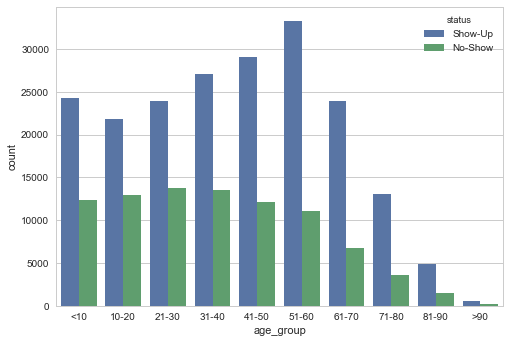

In [9]:
#Plotting status by age groups.
%matplotlib inline
import seaborn as sns

sns.set(style="whitegrid", color_codes=True)
sns.countplot(x="age_group", hue="status", data=patient_appt, order=group_names);

Step 4: Build a basic model to predict whether a patient shows up for their appointment.

In [62]:
#Frequency counts of number of show-up and no-shows.
patient_appt.status.value_counts()

#Converting patient_id column to string.
patient_appt['patient_id'] = patient_appt['patient_id'].astype(str)

In [63]:
#Analyzing summary statistics of the variables 
#Frpatient_appt.describe()

,age,diabetes,alcoholism,hypertension,handicap,smokes,tuberculosis
count,299900.000000,299900.000000,299900.000000,299900.000000,299900.000000,299900.000000,299900.000000
mean,37.808173,0.077973,0.025015,0.215899,0.020520,0.052374,0.000450
std,22.808943,0.268129,0.156171,0.411445,0.155929,0.222781,0.021212
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,113.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [64]:
#From the descriptive statistics values, we find that handicap variable has 5 levels.  So we convert it to str.
patient_appt.handicap.value_counts()
patient_appt['handicap'] = patient_appt['handicap'].astype(str)

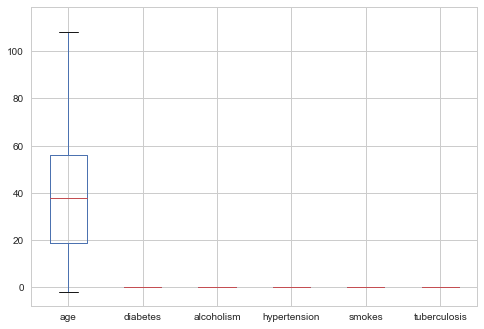

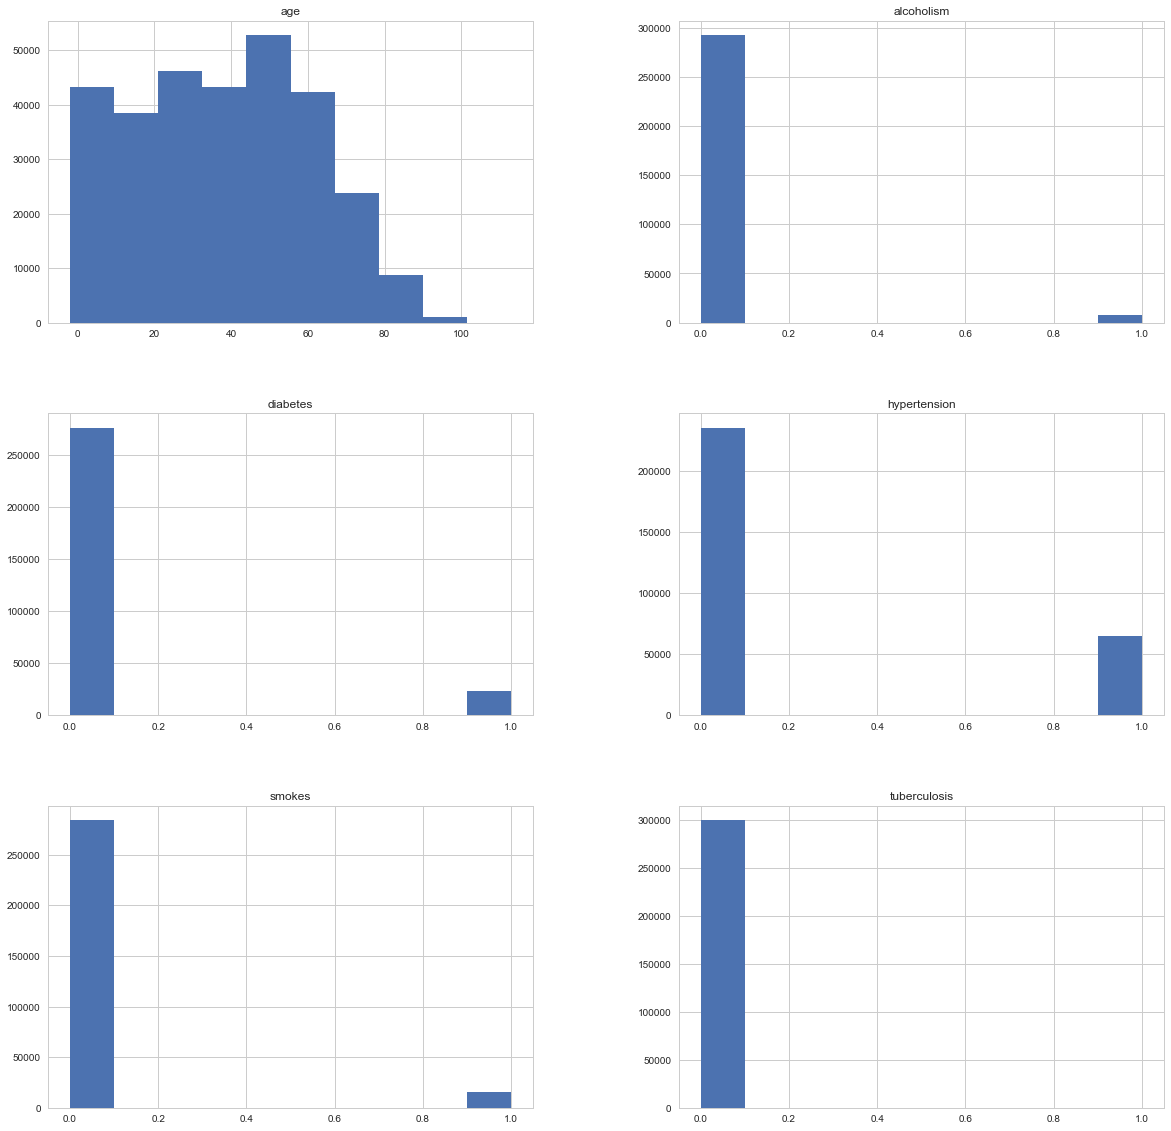

In [65]:
#Seeing distributions of variables for outliers, skewness etc.
import matplotlib.pyplot as plt
patient_appt.boxplot()
patient_appt.hist(figsize=(20,20));

In [66]:
#Separating independent (X) and dependent variable(Y).
X = patient_appt[['age','gender','diabetes','alcoholism','hypertension','handicap','smokes','tuberculosis','sms_reminder','day_of_week']]
y = patient_appt['status']
#Imputing variables with median incase there are missing values in future.  Not the best technique, but just for time being.
X_d = X.fillna(X.median())
#Getting binary dummy variables for categorical columns.
X_d = pd.get_dummies(X_d)
X_d.columns

Index(['age', 'diabetes', 'alcoholism', 'hypertension', 'smokes',
       'tuberculosis', 'gender_F', 'gender_M', 'handicap_0', 'handicap_1',
       'handicap_2', 'handicap_3', 'handicap_4', 'sms_reminder_No',
       'sms_reminder_Yes', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [13]:
#Scaling input variables for linear models because Age is in a different scale.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_d)
X_Mscaled = scaler.transform(X_d)

In [67]:
#Scaling input variables for linear models because Age is in a different scale.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_d)
X_Sscaled = scaler.transform(X_d)

In [68]:
#Using standard scaler for data partition because outlier effect is minimal.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Sscaled,y,random_state=42, stratify=y)

In [69]:
#Creating polynomial terms with degree 2 for regression.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2).fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

In [71]:
#Building logistic regression model with C value of 10 and checking training and test accuracies.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10,random_state=0)
logreg.fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.698
Test set score: 0.698


In [72]:
#Building Random Forest model and checking training and test accuracies.
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50,max_depth=40,random_state=0)
rfc.fit(X_train,y_train)
print("Training set score: {:.3f}".format(rfc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rfc.score(X_test, y_test)))

Training set score: 0.712
Test set score: 0.687


In [73]:
#Building Decision Tree model and checking training and test accuracies.
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 0)
dtc.fit(X_train,y_train)
print("Training set score: {:.3f}".format(dtc.score(X_train, y_train)))
print("Test set score: {:.3f}".format(dtc.score(X_test, y_test)))

Training set score: 0.712
Test set score: 0.684


In [42]:
#Building MLP Neural network model and checking training and test accuracies.
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)
print("Training set score: {:.3f}".format(mlp.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mlp.score(X_test, y_test)))

Training set score: 0.698
Test set score: 0.697
